# A practical introduction to image classification
In this notebook we introduce the image classification problem on a difficult dataset.
## The CIFAR dataset

You can download the data from here: https://www.cs.toronto.edu/~kriz/cifar.html

In particular, we are using the CIFAR-10 dataset in the Python version:
https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz (About 160 MB)

Untar the file in a directory named "cifar-10" placed in the current working directory

In [1]:
import numpy as np
import pickle
import pathlib
ddir = pathlib.Path("cifar-10")
print(f"We expect the data files in directory {ddir.absolute()}")

We expect the data files in directory /Users/iawilli/Documents/Master MSE/CompVis/notebooks/week05 + week06/cifar-10


In [2]:
with open(ddir/"batches.meta", 'rb') as fo:
    labelnames = pickle.load(fo)["label_names"]

data_tr = []
labels_tr = []
for i in range(1, 6):
    with open(ddir/"data_batch_{}".format(i), 'rb') as fo:
        alldata = pickle.load(fo, encoding='bytes')
    data_tr.append(alldata[b"data"])
    labels_tr.append(np.array(alldata[b"labels"]))
data_tr = np.vstack(data_tr)
labels_tr = np.hstack(labels_tr)

with open(ddir/"test_batch", 'rb') as fo:
    alldata = pickle.load(fo, encoding='bytes')
data_te = alldata[b"data"]
labels_te = np.array(alldata[b"labels"])

# %% We now have two datasets, one for training and one for testing

print("Training data and labels with shapes: ", data_tr.shape, labels_tr.shape)
print("Testing data and labels with shapes: ", data_te.shape, labels_te.shape)
print("Meaning of the label codes: ", list(enumerate(labelnames)))

Training data and labels with shapes:  (50000, 3072) (50000,)
Testing data and labels with shapes:  (10000, 3072) (10000,)
Meaning of the label codes:  [(0, 'airplane'), (1, 'automobile'), (2, 'bird'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'frog'), (7, 'horse'), (8, 'ship'), (9, 'truck')]


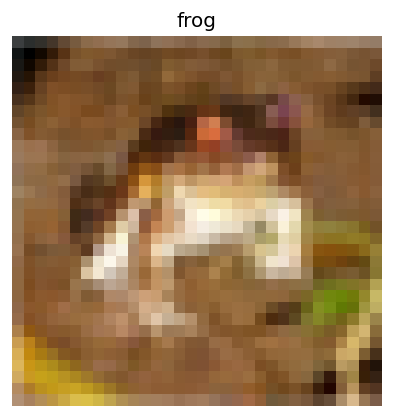

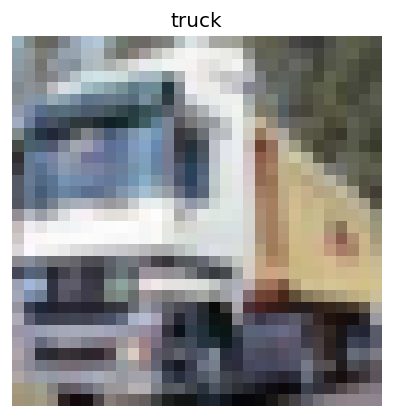

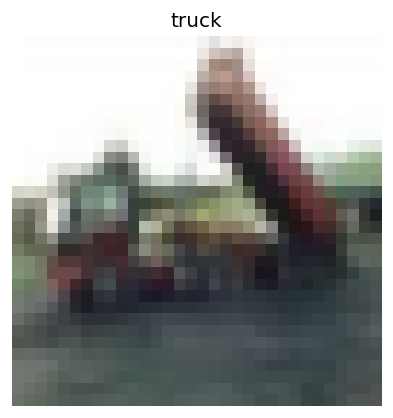

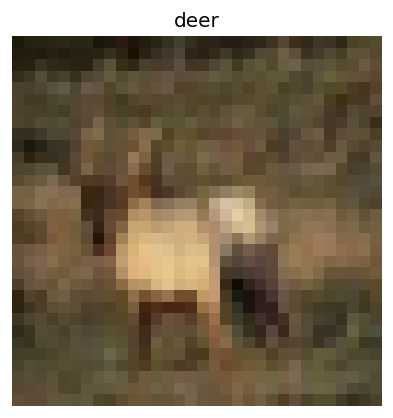

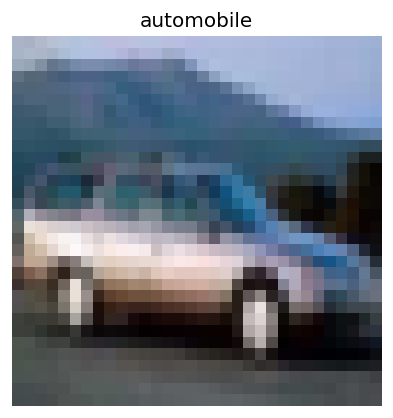

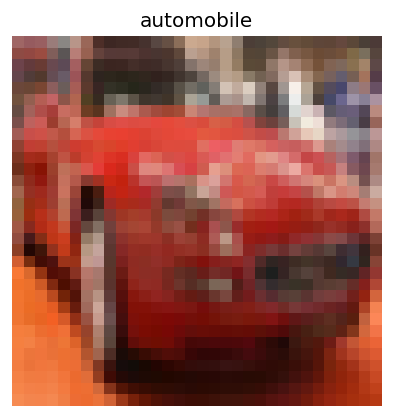

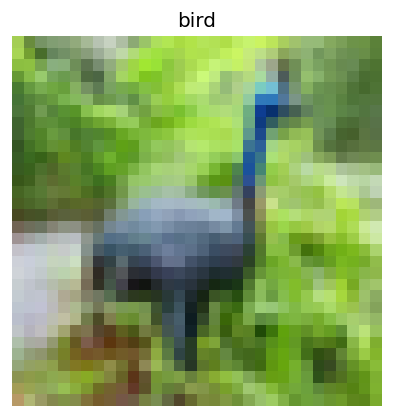

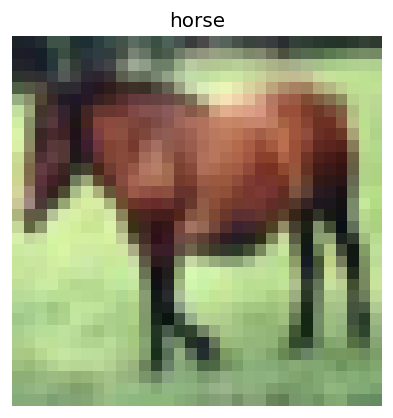

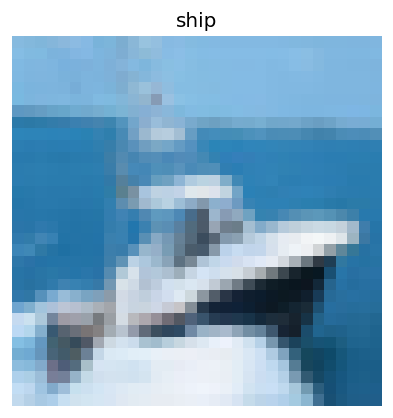

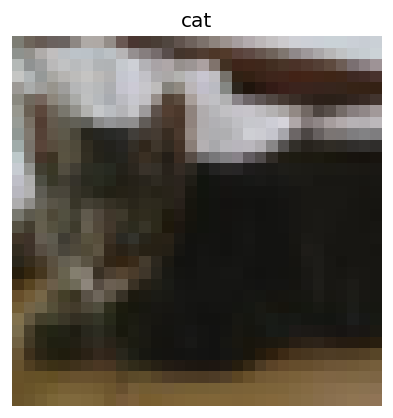

In [3]:
# %% Support function for drawing an image
import matplotlib.pyplot as plt
%matplotlib inline


def vec2im(imvector):
    """ Convert a vector to an image """
    im = np.reshape(imvector, (3, 32, 32))  # reshape
    # we want channels to be the last dimension, not the first.
    im = np.transpose(im, axes=(1, 2, 0))
    return im


def showim(im, l=None, ax=None):
    """ Displays the image im (1D vector with 3072 elements)
    in axis ax (or a new figure if not given),
    and set the title to the name
    corresponding to label l (if given)"""
    if ax is None:
        fig,ax = plt.subplots()
    ax.imshow(im)
    ax.axis("off")
    if l is not None:
        ax.set_title(labelnames[l])


# %% Let's visualize some of our training images
for i in range(10):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=120)
    showim(vec2im(data_tr[i]), l=labels_tr[i], ax=ax)
    plt.show()

## Exercise 1: implement a nearest-neighbor classifier approach in pixel space
Given a testing image, we want to look for the training image that is _closest_ when comparing the raw pixel values.
Remember that an image in our dataset is actually a 1D array with 3072 uint8 elements (i.e. 32x32x3 pixels, arranged in a line).

### 1.1: define a function that given two images, computes the euclidean distance between them
Each image is a point in 3072 dimensions.  You can use [`np.linalg.norm(...)`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html) to find the length of a 3072-dimensional vector...

Remember that you should cast both vectors to `float` before subtracting them.  Use [`ndarray.astype(float)`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.astype.html)

In [4]:
def distance(imvec1, imvec2):
    """ Returns the euclidean distance between two vectors im1 and im2 """
    return np.sum((imvec2.astype(float)-imvec1.astype(float))**2)**0.5

# Better but marginally more elegant
def distance(imvec1, imvec2):
    """ Returns the euclidean distance between two vectors im1 and im2 """
    return np.linalg.norm(imvec1.astype(float)-imvec2.astype(float))


print("Should be 1:", distance(np.array([0, 0]), np.array([0, 1])))
print("Should be 5:", distance(np.array([4, 0, 0]), np.array([0, 0, 3])))

Should be 1: 1.0
Should be 5: 5.0


### 1.2: Given a testing image, find the nearest training instance
Then print the true class of the testing instance, and the predicted class (i.e. the class of the closest training instance).

Do this for each of the first 20 testing images. Should take at most 1 second per image.

**Extension**: for each of the first 20 testing images, display it along with its class; besides it display the closest training image, and also the training image that is farthest away (use `fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)`)

In [ ]:
# see below

### 1.3: Compute the accuracy of your classifier over 100 random testing instances
How does it compare to the accuracy of a baseline classifier that just returns a random class (assuming that the 10 classes are equally distributed)? 

**Extension**: also compute the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

Ground truth label:  airplane
Estimated label:  airplane


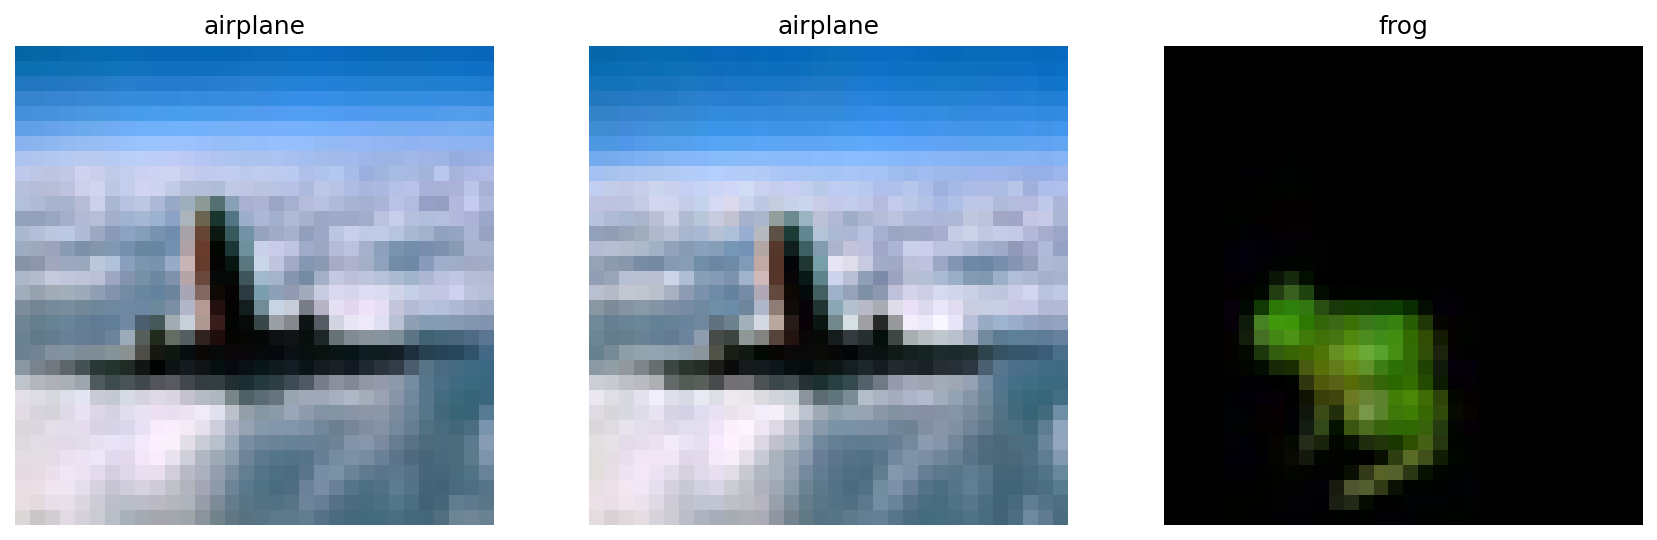

Ground truth label:  dog
Estimated label:  cat


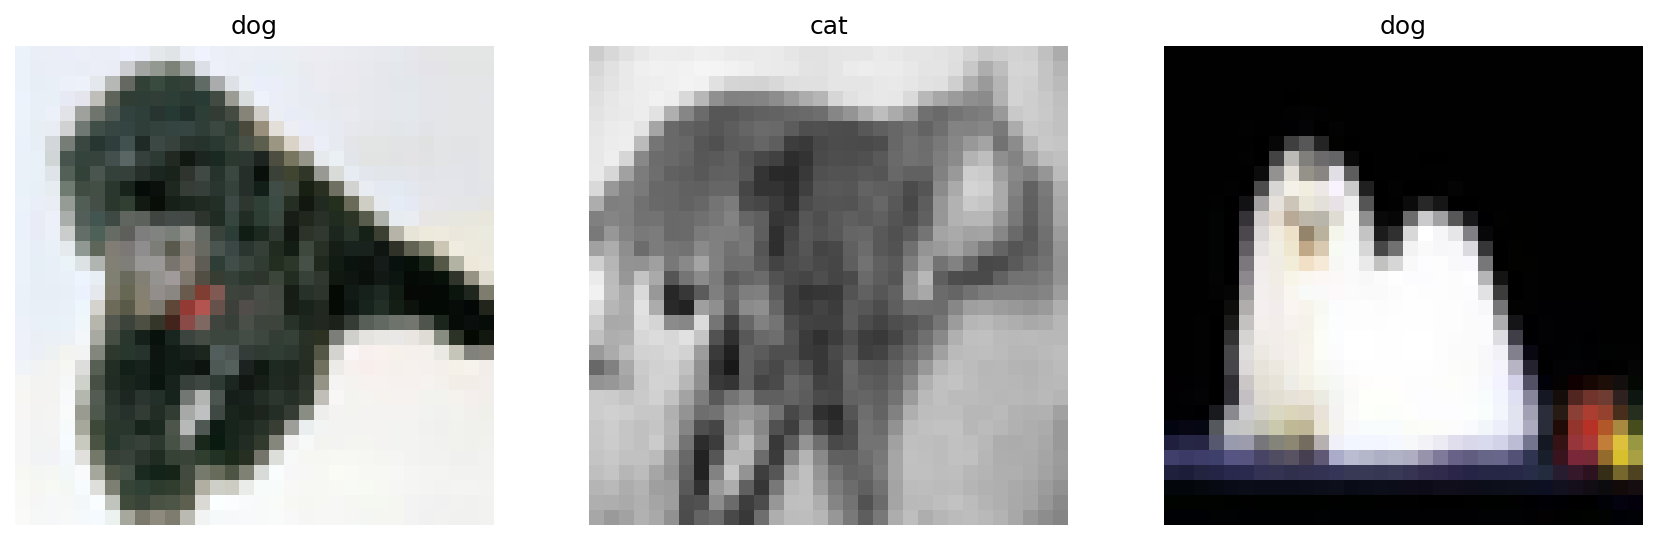

Ground truth label:  bird
Estimated label:  dog


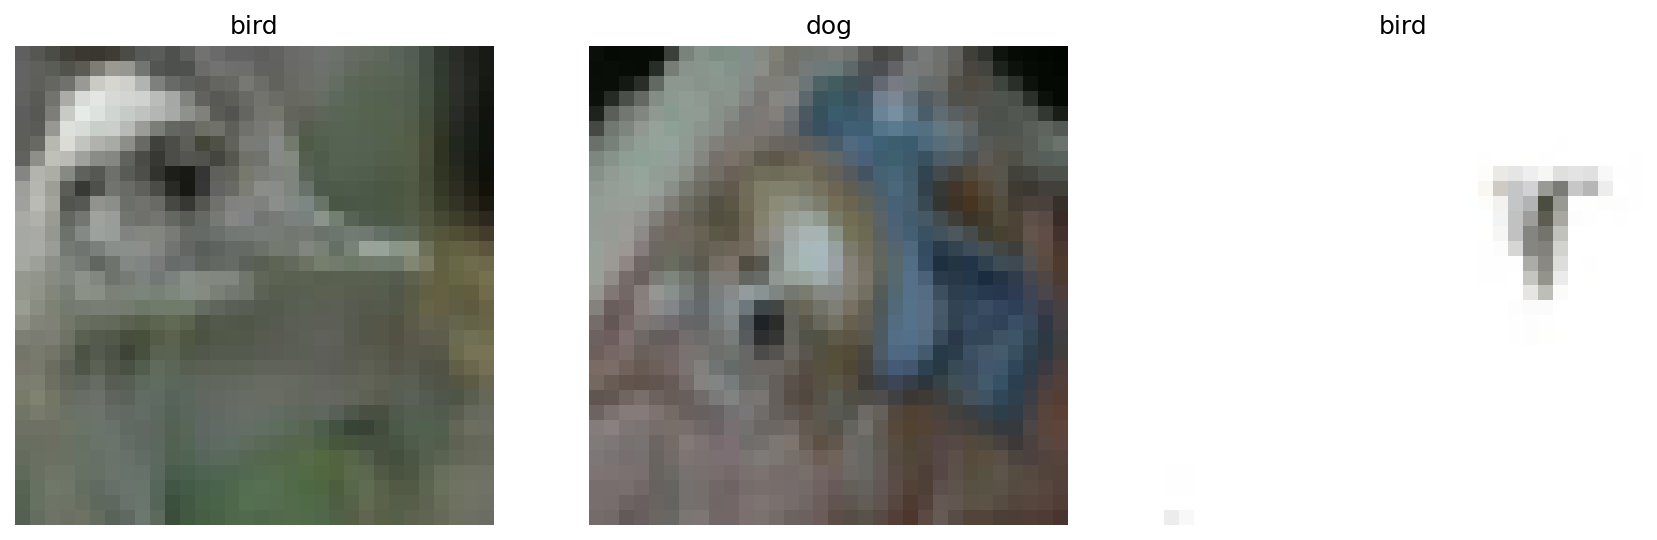

Ground truth label:  airplane
Estimated label:  airplane


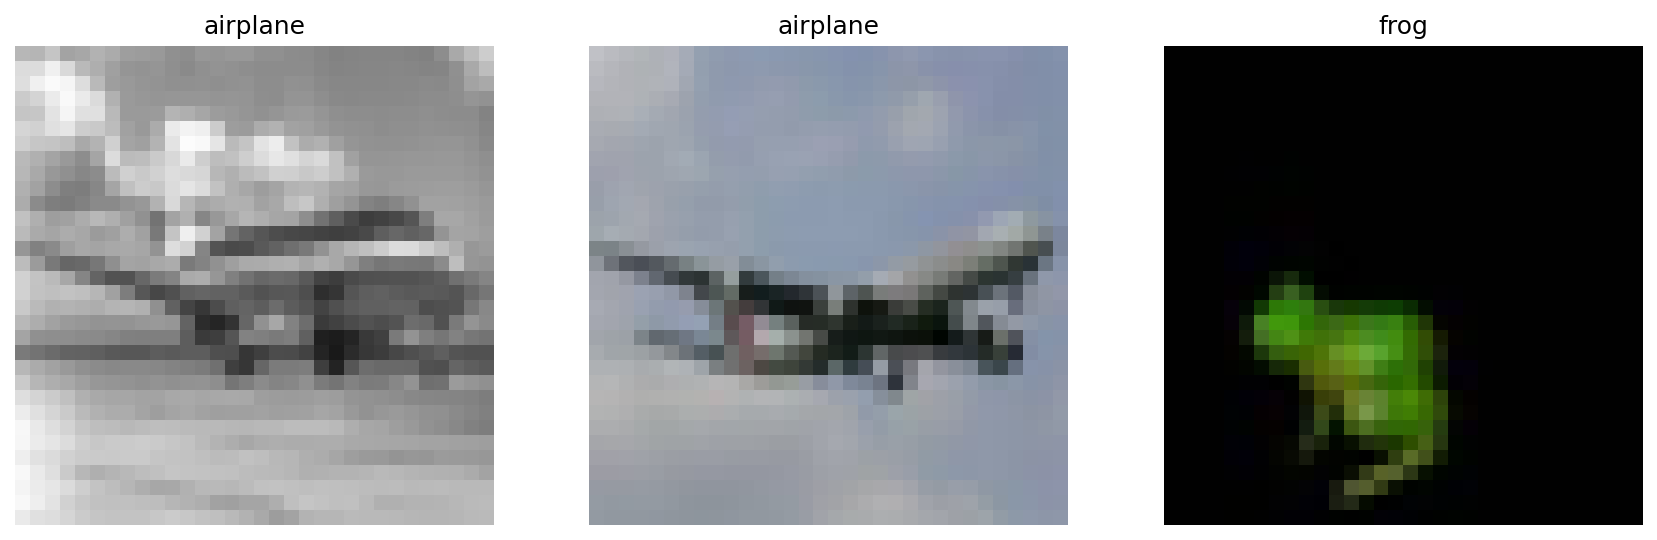

Ground truth label:  bird
Estimated label:  airplane


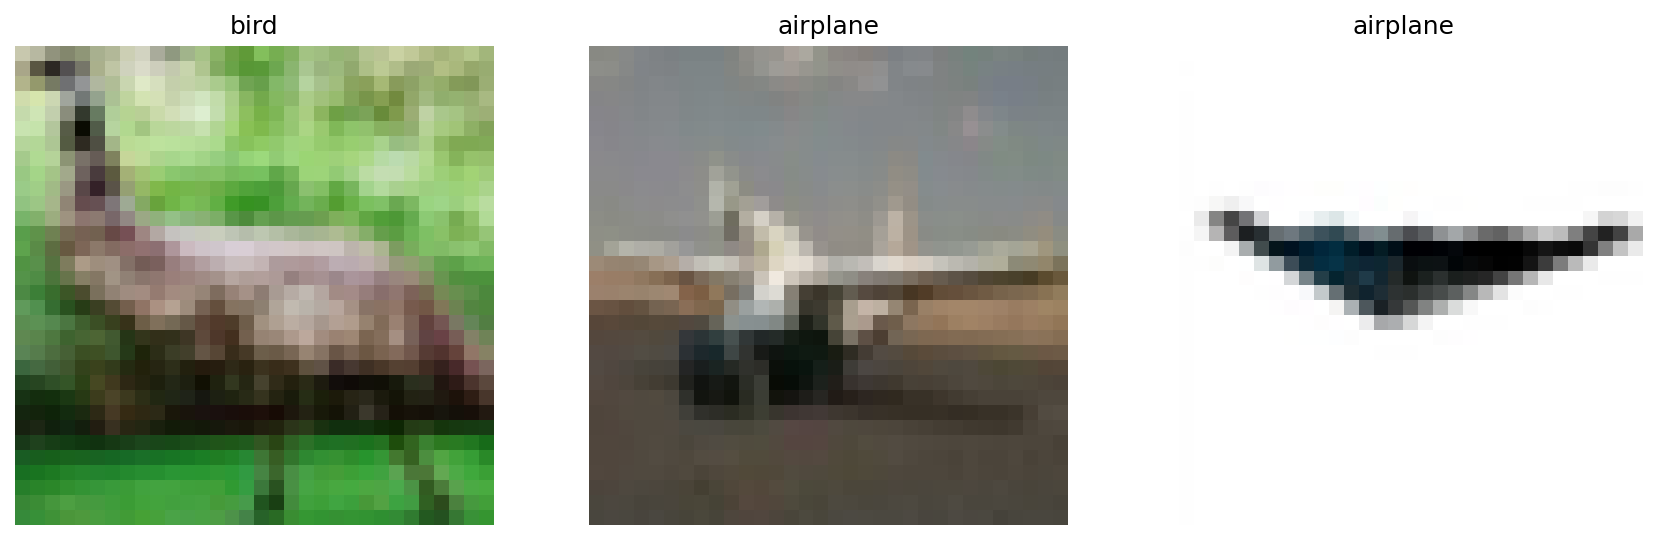

Ground truth label:  airplane
Estimated label:  airplane


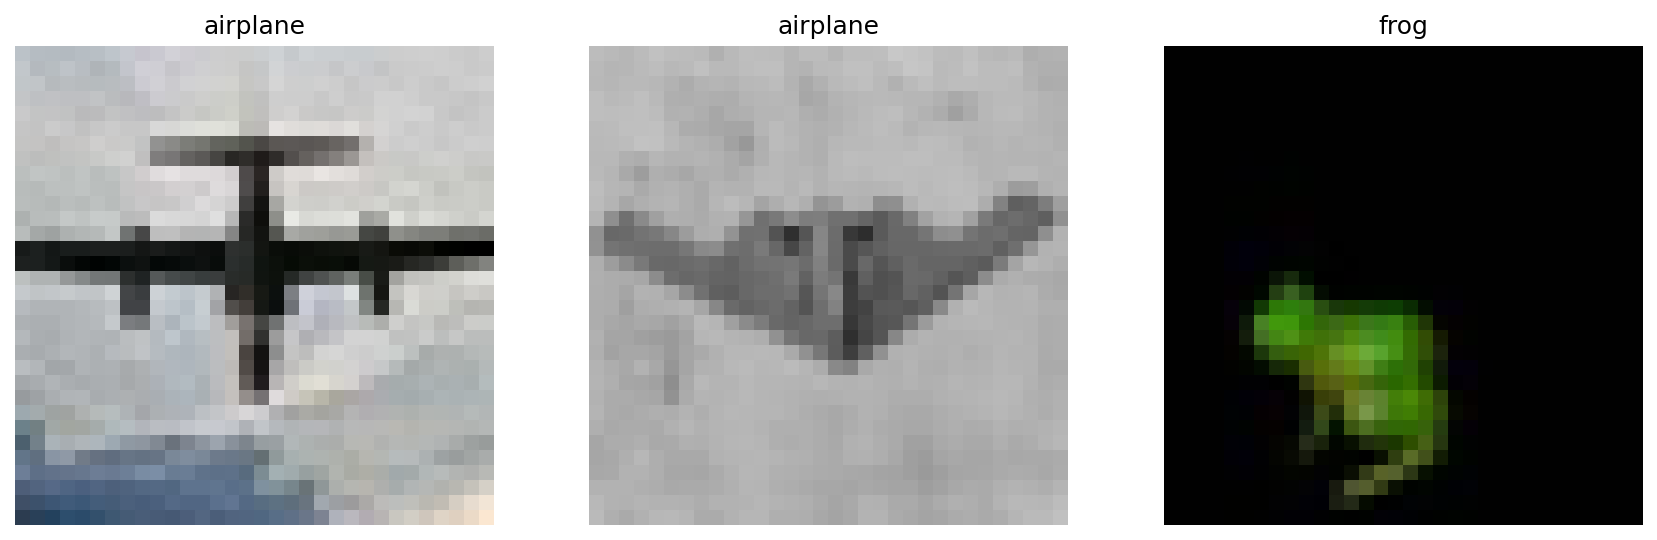

Ground truth label:  deer
Estimated label:  airplane


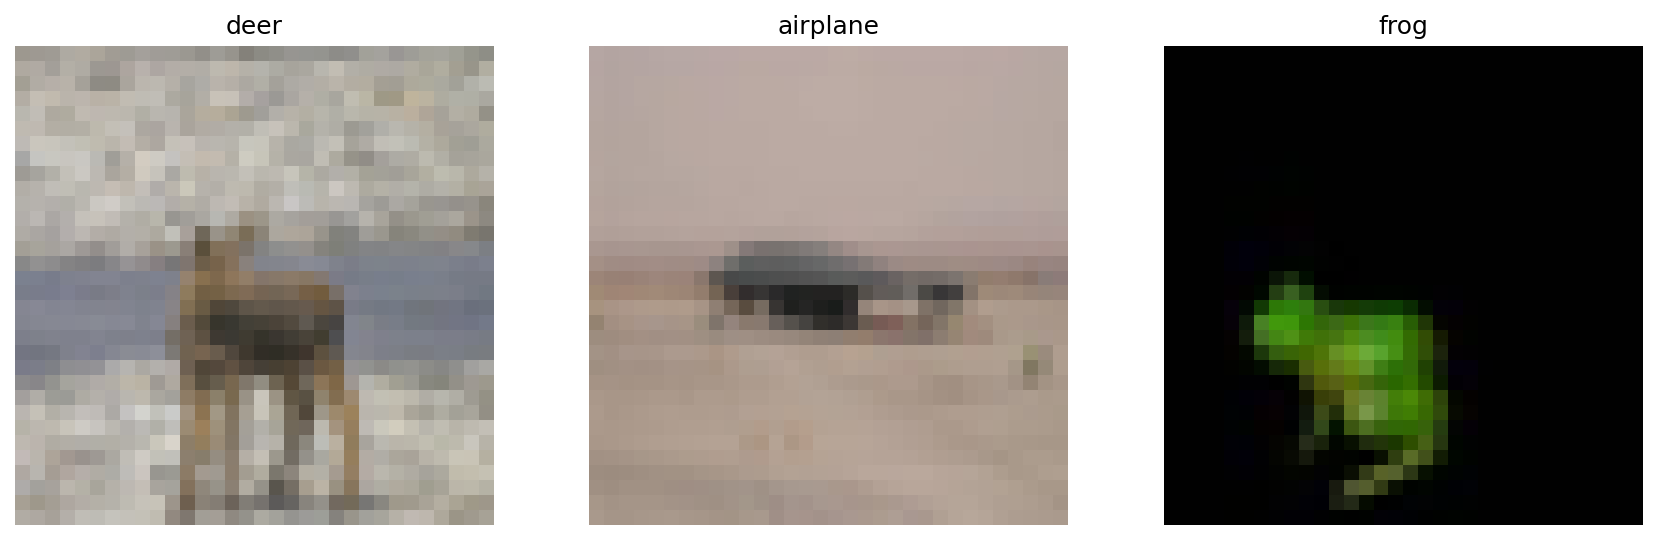

Ground truth label:  automobile
Estimated label:  bird


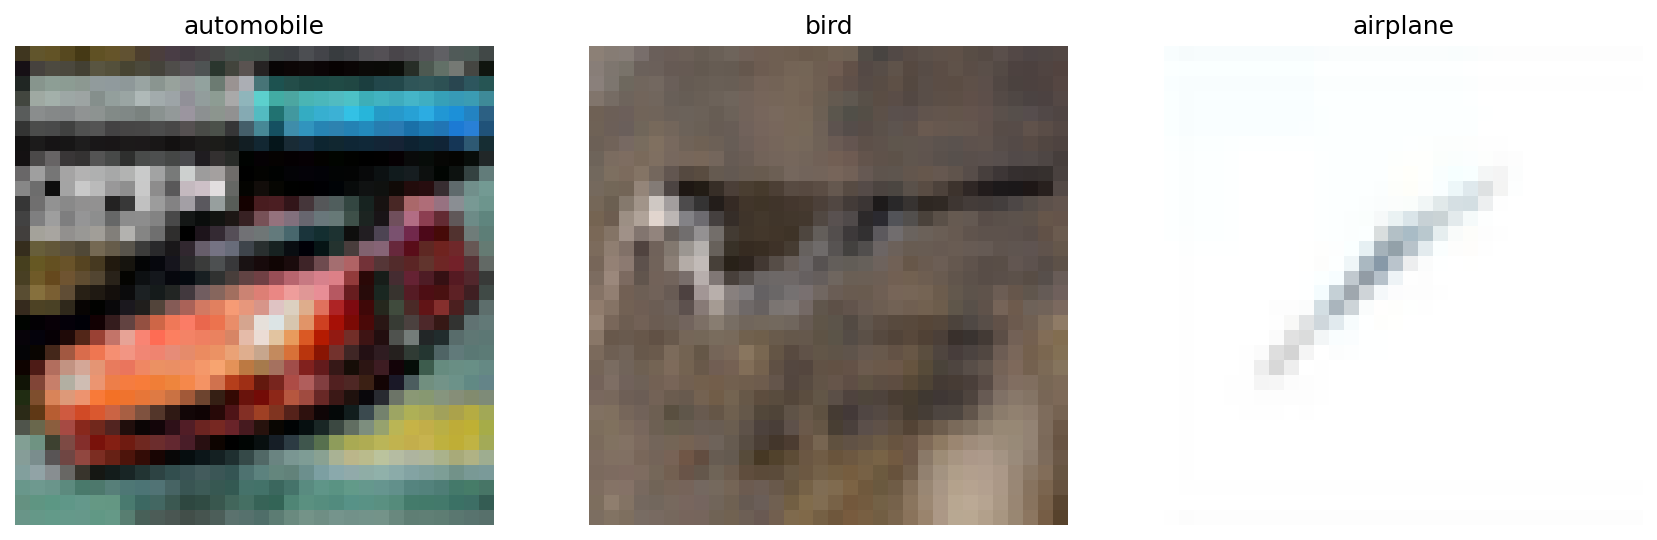

Ground truth label:  ship
Estimated label:  ship


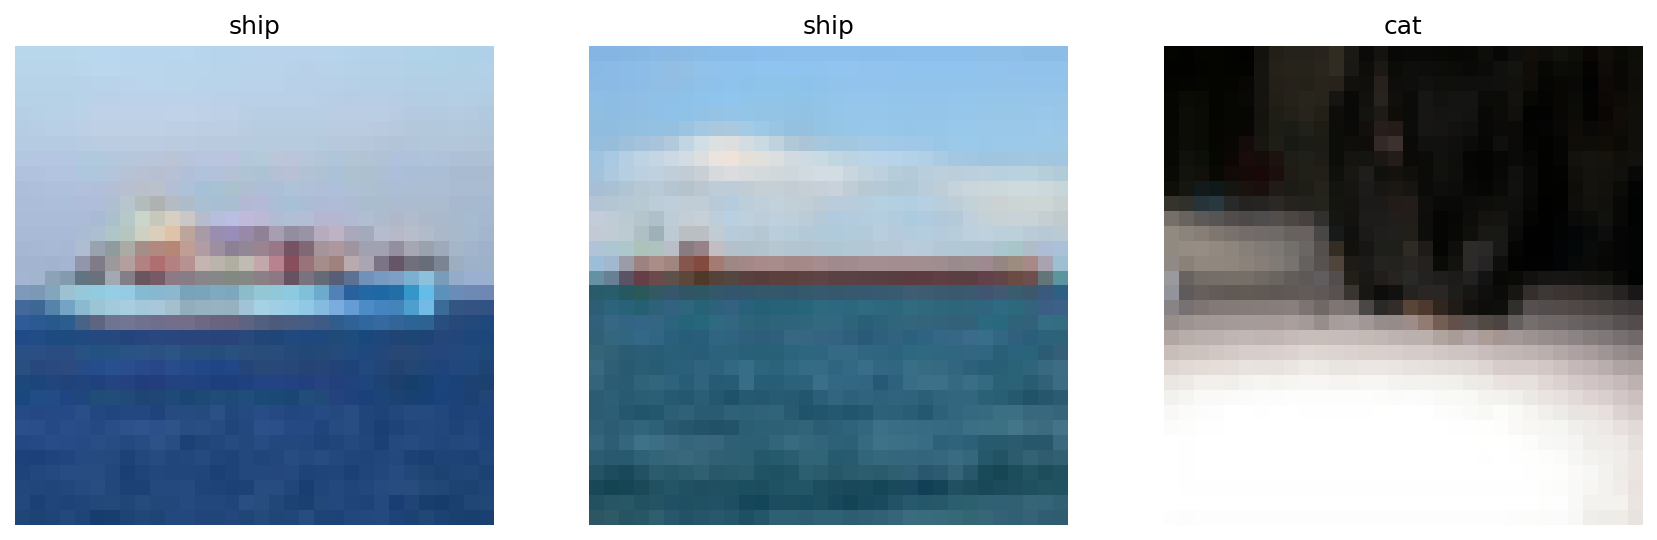

Ground truth label:  airplane
Estimated label:  airplane


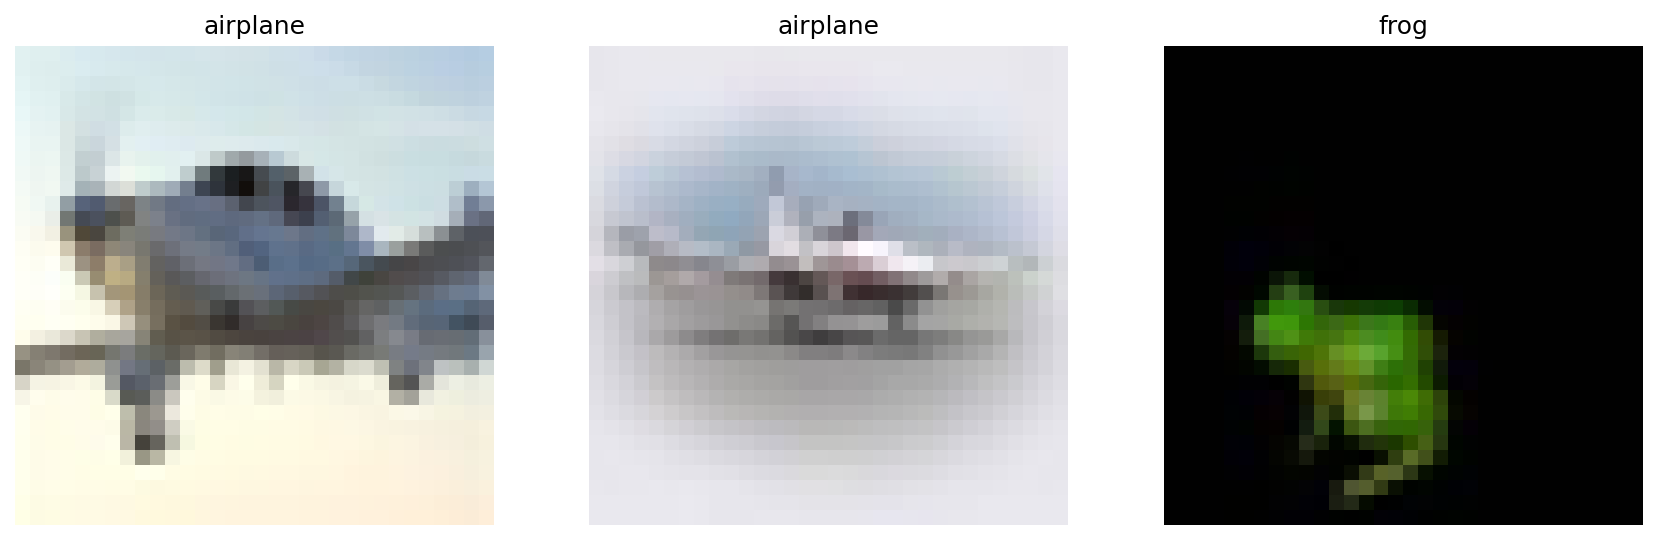

In [5]:
# %% Let's look for the closest (and farthest) training image to each of the first 20 testing images
y_true = []
y_pred = []
for testi in np.random.randint(len(data_te), size=(10,)):
    imvec = data_te[testi]
    l = labels_te[testi]
    # im is now our test image, and l is the ground truth label

    d = np.full(len(data_tr), np.nan)
    # for each training image, we'll save its distance from the query
    for i in range(len(data_tr)):
        d[i] = distance(data_tr[i], imvec)
    i_closest = np.argmin(d)  # this is the index of the closest image
    i_farthest = np.argmax(d)  # index of the farthest image

    print("Ground truth label: ", labelnames[l])
    print("Estimated label: ", labelnames[labels_tr[i_closest]], flush=True)

    y_true.append(l)
    y_pred.append(labels_tr[i_closest])

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14, 6), dpi=150)
    # draw the test image (and label) on the first axis
    showim(vec2im(data_te[testi]), l=labels_te[testi], ax=ax1)
    # draw the closest image (and label) on the second axis
    showim(vec2im(data_tr[i_closest]), l=labels_tr[i_closest], ax=ax2)
    # draw the farthest image (and label) on the third axis
    showim(vec2im(data_tr[i_farthest]), l=labels_tr[i_farthest], ax=ax3)

    plt.show()

Accuracy:  0.5
[[4 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1]]


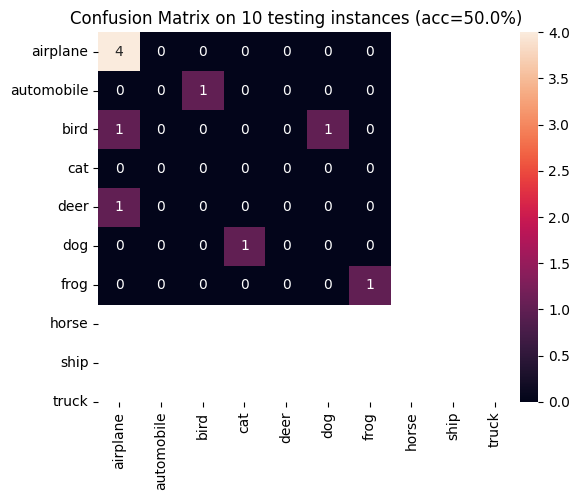

In [8]:
import sklearn.metrics

acc = np.mean(np.array(y_true) == np.array(y_pred))
print("Accuracy: ",acc)
cm = sklearn.metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
print(cm)

# Visualize the confusion matrix as an heatmap
import seaborn as sns
sns.heatmap(cm, annot=True, xticklabels=labelnames, yticklabels=labelnames)
plt.title(f"Confusion Matrix on {len(y_true)} testing instances (acc={acc*100}%)");

## Exercise 2: implement and evaluate a feature extraction approach
We are now going to extract a few features for each image (both training and testing). Then, we will train a classifier from the sklearn library on the training data, and evaluate it on testing data.

### 2.1: implement a simple feature extractor
Implement a function that given an image, returns the average value for red, green and blue in that image.

In [9]:
def extract_features(im):
    assert(im.shape[2] == 3)
    return np.mean(im,axis=(0,1))

testim = np.array([
    [[1,2,3],[2,3,4]],
    [[0,1,2],[1,2,3]],
])
print("shape of testim: ", testim.shape)
print("Should return [1 2 3]: ",extract_features(testim))

shape of testim:  (2, 2, 3)
Should return [1 2 3]:  [1. 2. 3.]


### 2.2: compute features for the whole training set and testing set
Build an array `features_tr` with shape `(50000,3)` containing the features for each training image (one per row).

Build an array `features_te` with shape `(10000,3)` containing the features for each testing image (one per row).

In [10]:
features_tr = []
for vec in data_tr:
    im = vec2im(vec)
    features_tr.append(extract_features(im))
features_tr = np.array(features_tr)
print(features_tr.shape)

features_te = []
for vec in data_te:
    im = vec2im(vec)
    features_te.append(extract_features(im))
features_te = np.array(features_te)
print(features_te.shape)

(50000, 3)
(10000, 3)


### 2.3: train a sklearn classifier on the training set, and compute its accuracy on the testing set

You can use any classifier, such as a K-Nearest-Neighbors classifier:

To create:
`clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`

To train:
`clf.fit(features_tr, labels_tr)`

To use it on new images"
`predicted_labels_te = clf.predict(features_te)`

### 2.4: extensions

- Also compute the confusion matrix.
- Explore how the accuracy changes if we use more than 1 neighbor.
- When using more than one neighbor (try using many, e.g. 100), the classifier can also return *class probabilities*; read the documentation for [`clf.predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.predict_proba).  For each of the first 20 testing images, dispay the testing image and a bar plot of the probability for the 3 most probable classes for that image according to our classifier.

In [11]:
import sklearn.neighbors
import sklearn.ensemble

# Classifiers we want to try
clfs = [
    sklearn.ensemble.RandomForestClassifier(),
    sklearn.neighbors.KNeighborsClassifier(n_neighbors=1),
    sklearn.neighbors.KNeighborsClassifier(n_neighbors=3),
    sklearn.neighbors.KNeighborsClassifier(n_neighbors=10),
    sklearn.neighbors.KNeighborsClassifier(n_neighbors=100),
]

for clf in clfs:    
    clf.fit(features_tr, labels_tr)
    y_pred = clf.predict(features_te)
    acc = sklearn.metrics.accuracy_score(y_true=labels_te, y_pred=y_pred)
    print(f"classifier {clf} has accuracy {acc}")

classifier RandomForestClassifier() has accuracy 0.2157
classifier KNeighborsClassifier(n_neighbors=1) has accuracy 0.1767
classifier KNeighborsClassifier(n_neighbors=3) has accuracy 0.187
classifier KNeighborsClassifier(n_neighbors=10) has accuracy 0.2153
classifier KNeighborsClassifier(n_neighbors=100) has accuracy 0.2455


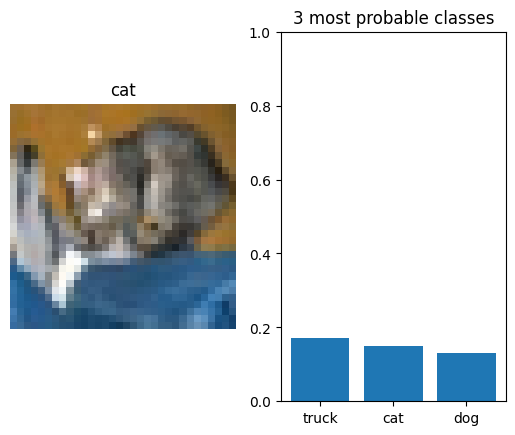

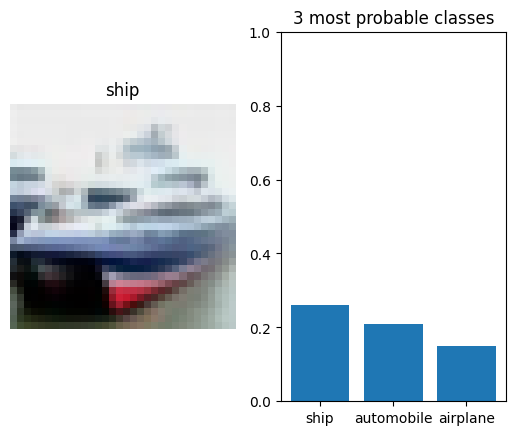

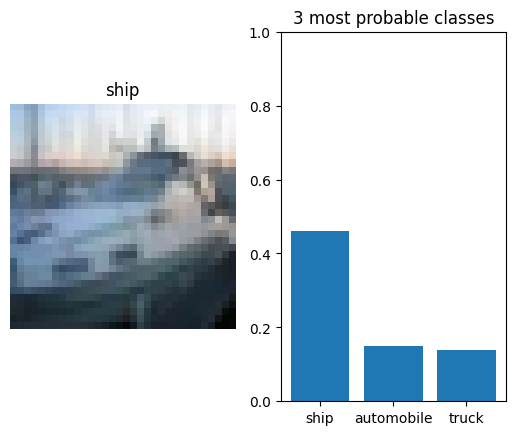

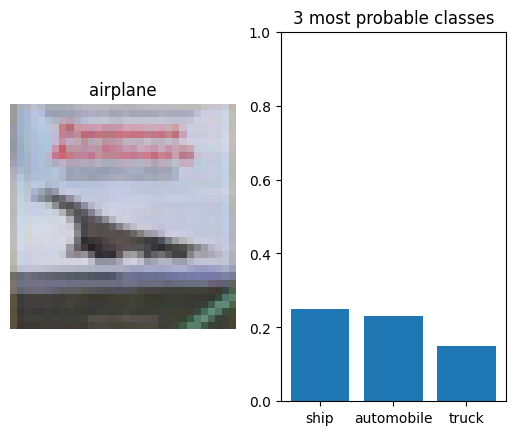

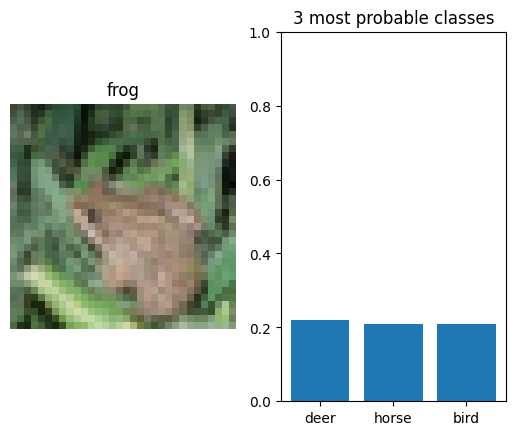

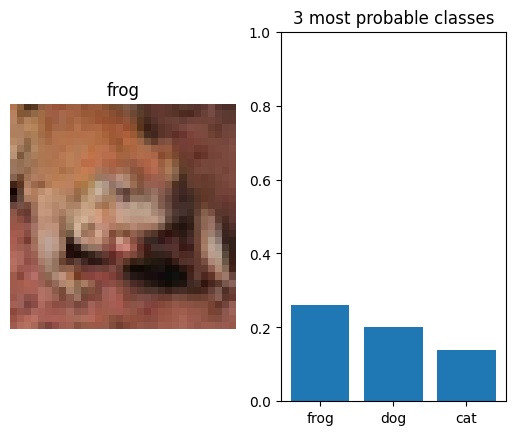

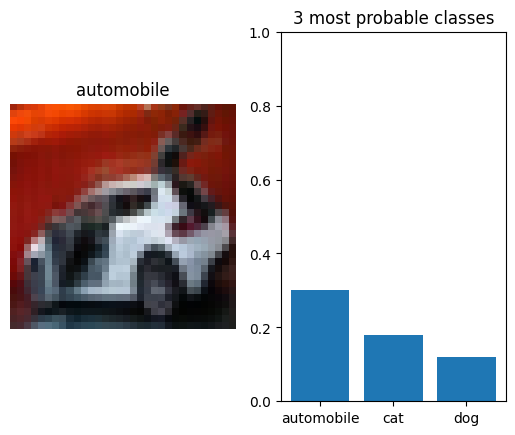

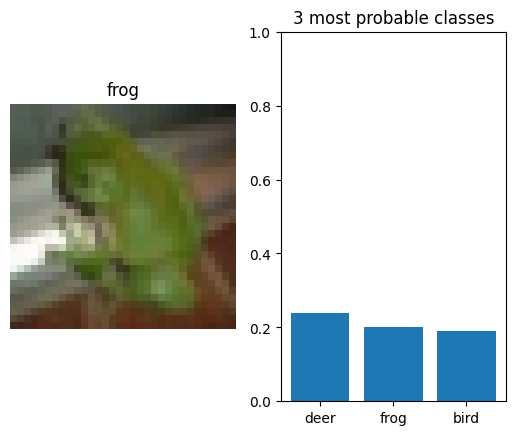

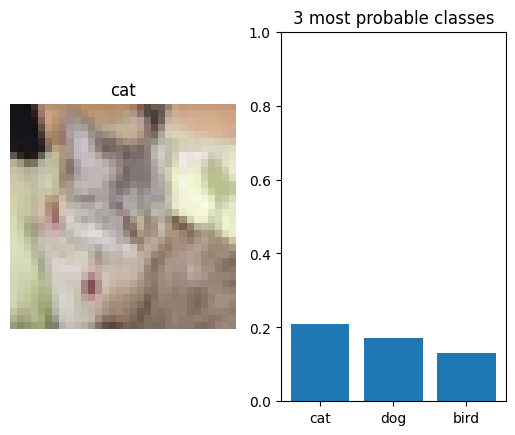

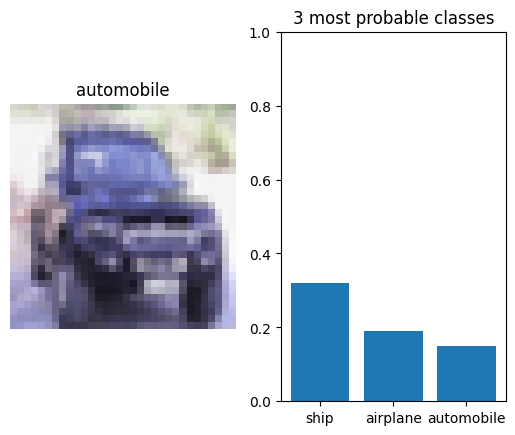

In [12]:
clf = clfs[-1] # take the last classifier we trained
y_proba = clf.predict_proba(features_te)
for testi in range(10):
    p = y_proba[testi,:]
    ix = np.argsort(p)[:-4:-1] # indices of the 3 largest elements
    
    fig,(ax1,ax2) = plt.subplots(ncols=2)
    showim(vec2im(data_te[testi]), l=labels_te[testi], ax=ax1)
    ax2.bar(x=[1,2,3], height=p[ix])
    ax2.set(ylim=[0,1],
            xticks=[1,2,3],
            xticklabels=[labelnames[i] for i in ix],
            title="3 most probable classes")

### 2.5: try extracting different/better features, and check how the accuracy changes

Consider the different options proposed below.  For each, compute on the test set the accuracy of the classifier learned from the training set.

- two random numbers (2 features).  Which accuracy do we expect?
- five random numbers (5 features).  Which accuracy do we expect?
- the average brightness of the image -- i.e. the mean value (1 feature)
- the average RGB values in the top half and in the bottom half (6 features)
- the mean value and variance of the image in each of the four quadrants (8 features)
- the mean value and variance of the intensity of the gradient of the image in each of the four quadrants (8 features)
- the concatenation of all above features
- (optional) the Histogram of Oriented Gradients feature descriptor, as computed by the function `skimage.feature.hog(im)`.  [Read more](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html#sphx-glr-auto-examples-features-detection-plot-hog-py).

In [13]:
import skimage.feature
import skimage.filters

def extract_features(im):
    imgrad = skimage.filters.sobel(skimage.color.rgb2gray(im))
    return np.hstack((
        # Average brightness
        np.mean(im[:]),
        # Average RGB on top/bottom half
        np.mean(im[:16,:],axis=(0,1)),
        np.mean(im[16:,:],axis=(0,1)),
        # Average value in each quarter
        np.mean(im[16:,16:],axis=(0,1,2)),
        np.mean(im[16:,:16],axis=(0,1,2)),
        np.mean(im[:16,16:],axis=(0,1,2)),
        np.mean(im[:16,:16],axis=(0,1,2)),
        # Std dev of values in each quarter
        np.std(im[16:,16:],axis=(0,1,2)),
        np.std(im[16:,:16],axis=(0,1,2)),
        np.std(im[:16,16:],axis=(0,1,2)),
        np.std(im[:16,:16],axis=(0,1,2)),
        # Average magnitude of the gradient on top/bottom half
        np.mean(imgrad[:16,:]),
        np.mean(imgrad[16:,:]),
        np.std(imgrad[:16,:]),
        np.std(imgrad[16:,:]),
    ))


features_tr = []
for vec in data_tr:
    im = vec2im(vec)
    features_tr.append(extract_features(im))
features_tr = np.array(features_tr)

features_te = []
for vec in data_te:
    im = vec2im(vec)
    features_te.append(extract_features(im))
features_te = np.array(features_te)

clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=100)
clf.fit(features_tr, labels_tr)
y_pred = clf.predict(features_te)
sklearn.metrics.accuracy_score(y_true=labels_te, y_pred=y_pred)

0.358

## Exercise 3: train a simple feedforward neural network to solve the classification task

The code below defines a classic feedforward NN architecture with many 3072 input neurons, one hidden layer with 100 neurons, and 10 output neurons, used for classification.  Train the network for a few epochs and check its validation accuracy.

What if you increase the number of neurons in the hidden layer?

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(100, input_shape=data_tr[0].shape))
model.add(Activation("sigmoid"))
model.add(Dense(10))
model.add(Activation("softmax"))

# For a multi-class classification problem
model.compile(optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

# Convert labels to categorical one-hot encoding
labels_tr_oh = keras.utils.to_categorical(labels_tr, num_classes=10)
labels_te_oh = keras.utils.to_categorical(labels_te, num_classes=10)

# Train the model, iterating on the data in batches of 32 samples
model.fit(data_tr.astype(float)/255, labels_tr_oh, epochs=5, batch_size=32,
          validation_data=(data_te.astype(float)/255, labels_te_oh))

2023-01-03 16:22:37.107541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-03 16:22:37.107648: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Epoch 1/5


2023-01-03 16:22:39.536814: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-03 16:22:39.805328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.9026 - accuracy: 0.3243

2023-01-03 16:22:59.918989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 23s 14ms/step - loss: 1.9026 - accuracy: 0.3243 - val_loss: 1.8376 - val_accuracy: 0.3533
Epoch 2/5
1563/1563 [==============================] - 21s 13ms/step - loss: 1.7639 - accuracy: 0.3748 - val_loss: 1.7203 - val_accuracy: 0.3983
Epoch 3/5
1563/1563 [==============================] - 21s 14ms/step - loss: 1.7158 - accuracy: 0.3920 - val_loss: 1.7118 - val_accuracy: 0.3935
Epoch 4/5
1563/1563 [==============================] - 23s 15ms/step - loss: 1.6787 - accuracy: 0.4037 - val_loss: 1.6812 - val_accuracy: 0.4029
Epoch 5/5
1563/1563 [==============================] - 21s 14ms/step - loss: 1.6547 - accuracy: 0.4112 - val_loss: 1.6700 - val_accuracy: 0.3974


### 3.1
Train the network for a while, then for each of the first 20 testing images, dispay the testing image and a bar plot of the probability for the 3 most probable classes for that image according to our network.

## Exercise 4: train a simple feedforward convolutional neural network to solve the classification task (trailer for next week)

In [18]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

images_tr = []
for vec in data_tr:
    images_tr.append(vec2im(vec))
images_tr = np.array(images_tr)

images_te = []
for vec in data_te:
    images_te.append(vec2im(vec))
images_te = np.array(images_te)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=images_tr[0].shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

# For a multi-class classification problem
model.compile(optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

# Convert labels to categorical one-hot encoding
labels_tr_oh = keras.utils.to_categorical(labels_tr, num_classes=10)
labels_te_oh = keras.utils.to_categorical(labels_te, num_classes=10)

# Train the model, iterating on the data in batches of 32 samples
model.fit(images_tr.astype(float)/255, labels_tr_oh, epochs=5, batch_size=32,
          validation_data=(images_te.astype(float)/255, labels_te_oh))

Epoch 1/5


2023-01-03 16:24:41.040653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.5048 - accuracy: 0.4490

2023-01-03 16:25:16.465813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 39s 24ms/step - loss: 1.5048 - accuracy: 0.4490 - val_loss: 1.1089 - val_accuracy: 0.6047
Epoch 2/5
1563/1563 [==============================] - 39s 25ms/step - loss: 1.0751 - accuracy: 0.6167 - val_loss: 0.9505 - val_accuracy: 0.6723
Epoch 3/5
1563/1563 [==============================] - 39s 25ms/step - loss: 0.9172 - accuracy: 0.6763 - val_loss: 0.8315 - val_accuracy: 0.7119
Epoch 4/5
1563/1563 [==============================] - 36s 23ms/step - loss: 0.8199 - accuracy: 0.7115 - val_loss: 0.7715 - val_accuracy: 0.7350
Epoch 5/5
1563/1563 [==============================] - 30s 19ms/step - loss: 0.7515 - accuracy: 0.7370 - val_loss: 0.7433 - val_accuracy: 0.7443


 12/313 [>.............................] - ETA: 1s  

2023-01-03 16:29:00.724981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 4ms/step


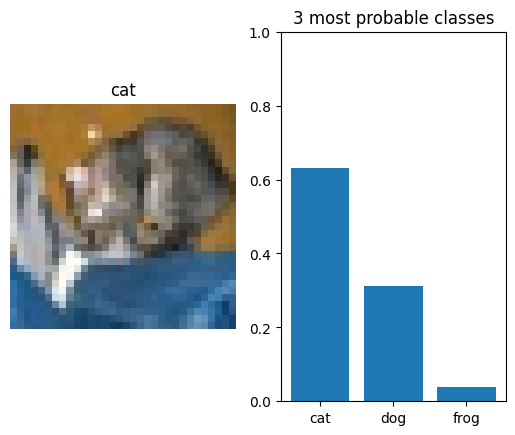

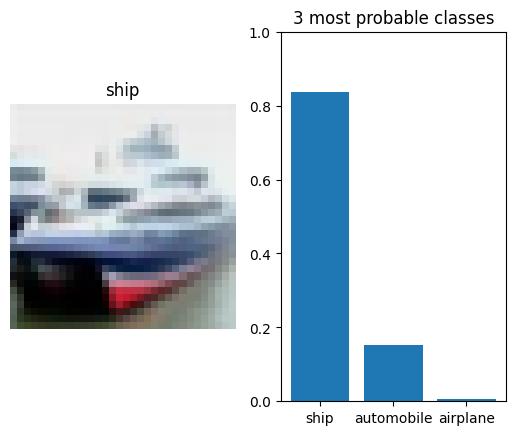

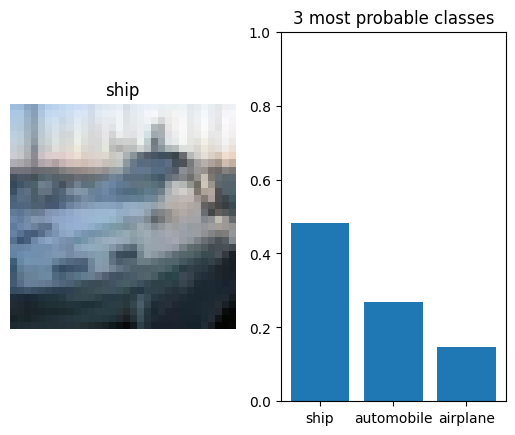

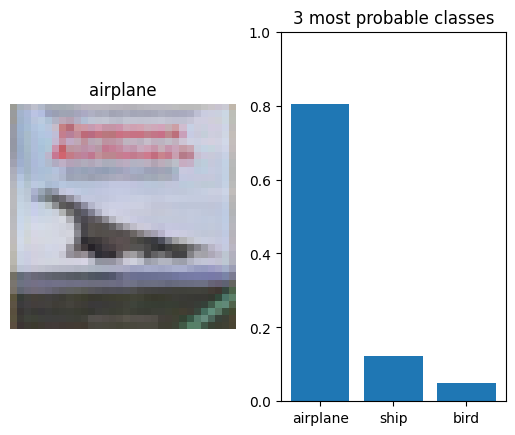

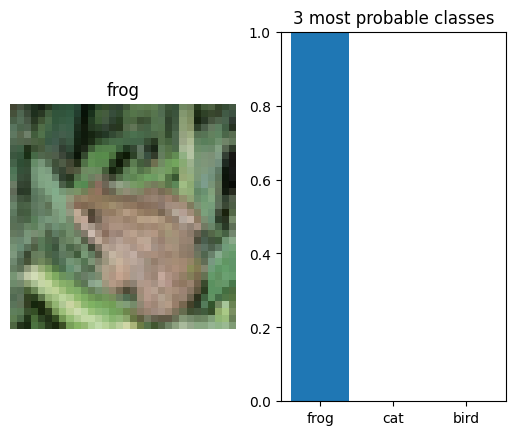

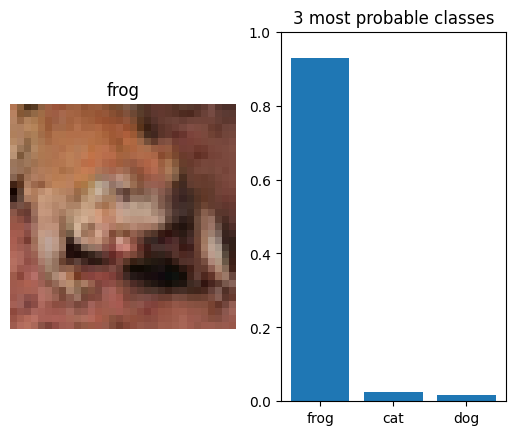

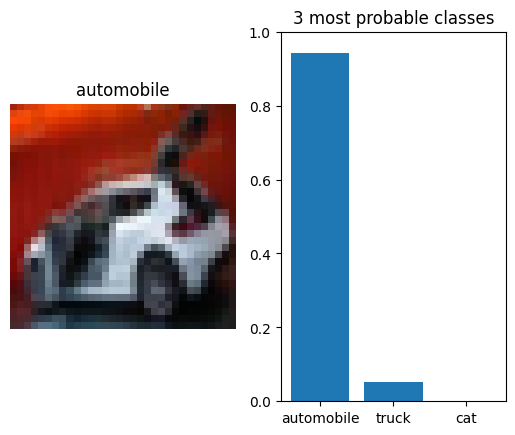

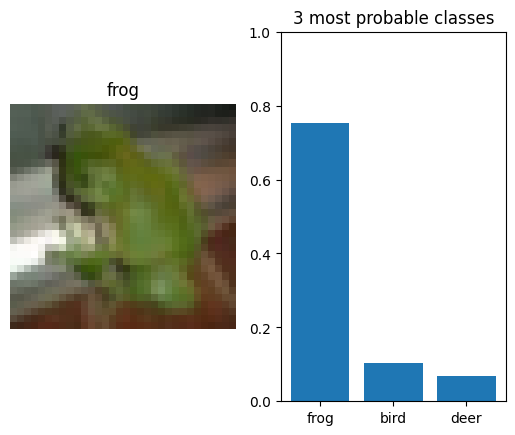

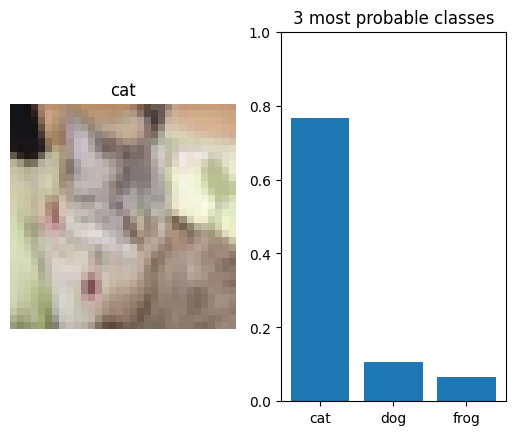

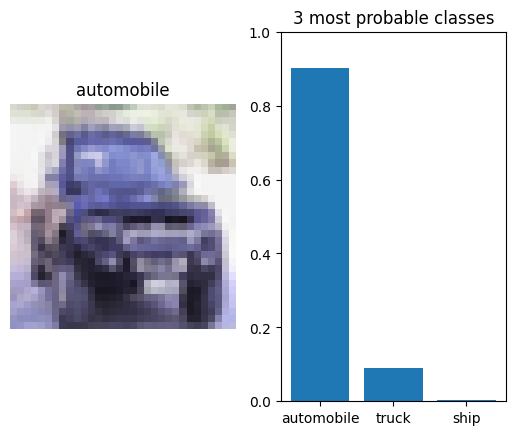

In [16]:
y_proba = model.predict(images_te.astype(float)/255)
for testi in range(10):
    p = y_proba[testi,:]
    ix = np.argsort(p)[:-4:-1] # indices of the 3 largest elements
    
    fig,(ax1,ax2) = plt.subplots(ncols=2)
    showim(vec2im(data_te[testi]), l=labels_te[testi], ax=ax1)
    ax2.bar(x=[1,2,3], height=p[ix])
    ax2.set(ylim=[0,1],
            xticks=[1,2,3],
            xticklabels=[labelnames[i] for i in ix],
            title="3 most probable classes")